In [1]:
%matplotlib inline
from scipy.optimize import dual_annealing
import numpy as np
import scipy.stats as scs
from matplotlib import pyplot as plt
from sklearn.gaussian_process.kernels import Matern
from collections import Counter
from mpl_toolkits.basemap import Basemap
from geopy.geocoders import Nominatim
from tqdm import tqdm
from datetime import datetime
import itertools
from itertools import permutations
from scipy.spatial import distance_matrix
import matplotlib
import matplotlib.colors as mcolors
from sklearn import metrics
import pickle

### Model for the whole UK - Gamma

In [77]:
### load gamma
model_version = 10
target_distribution = "gamma_hurdle"
base_nn = "HConvLSTM_tdscale" #(Keep this fixed)

# Run this to get the prediction data in a variable named city_data
# Getting data
sys.path.append('../')
import glms
import pickle
import torch

path_ = f"Checkpoints/uk_rain_DGLM_{base_nn}_{target_distribution}/lightning_logs/version_{model_version}/"
ckpt_path = glms.NeuralDGLM.get_ckpt_path(os.path.join(path_,"checkpoints"))
print([path_,ckpt_path])
scaler_features, scaler_target = glms.NeuralDGLM.load_scalers(path_)
model = glms.NeuralDGLM.load_from_checkpoint(ckpt_path, save_hparams=False, scaler_features=scaler_features, scaler_target=scaler_target)
model.freeze()
model.eval()

test_output = pickle.load( open(os.path.join(path_,"test_output_2014_2019-07.pkl"),"rb") )
#########

['Checkpoints/uk_rain_DGLM_HConvLSTM_tdscale_gamma_hurdle/lightning_logs/version_10/', 'Checkpoints/uk_rain_DGLM_HConvLSTM_tdscale_gamma_hurdle/lightning_logs/version_10/checkpoints/epoch=5-step=11694-val_loss_loss=-0.394-val_metric_mse_rain=22.220.ckpt']


In [78]:
# create list of locations
loc_lat_lon = ['lat_57.75_56.15_lon_-5.75_-4.15', 'lat_53.75_52.15_lon_-3.35_-1.75', 'lat_53.75_52.15_lon_-2.95_-1.35', 'lat_55.75_54.15_lon_-5.35_-3.75', 'lat_55.75_54.15_lon_-4.95_-3.35', 'lat_53.35_51.75_lon_-0.95_0.65', 'lat_52.95_51.35_lon_-10.95_-9.35', 'lat_54.95_53.35_lon_-9.75_-8.15', 'lat_54.95_53.35_lon_-9.35_-7.75', 'lat_51.75_50.15_lon_-4.95_-3.35', 'lat_51.75_50.15_lon_-4.55_-2.95', 'lat_54.55_52.95_lon_-5.75_-4.15', 'lat_54.55_52.95_lon_-5.35_-3.75', 'lat_51.35_49.75_lon_-0.55_1.05', 'lat_51.35_49.75_lon_-0.15_1.45', 'lat_54.15_52.55_lon_-2.55_-0.95', 'lat_54.15_52.55_lon_-2.15_-0.55', 'lat_57.35_55.75_lon_-3.75_-2.15', 'lat_57.35_55.75_lon_-3.35_-1.75', 'lat_53.35_51.75_lon_-10.95_-9.35', 'lat_53.35_51.75_lon_-10.55_-8.95', 'lat_55.35_53.75_lon_-10.95_-9.35', 'lat_55.35_53.75_lon_-10.55_-8.95', 'lat_52.95_51.35_lon_-8.55_-6.95', 'lat_52.95_51.35_lon_-8.15_-6.55', 'lat_54.95_53.35_lon_-6.95_-5.35', 'lat_54.95_53.35_lon_-6.55_-4.95', 'lat_51.75_50.15_lon_-2.15_-0.55', 'lat_51.75_50.15_lon_-1.75_-0.15', 'lat_54.15_52.55_lon_-9.35_-7.75', 'lat_54.15_52.55_lon_-8.95_-7.35', 'lat_57.75_56.15_lon_-5.35_-3.75', 'lat_53.75_52.15_lon_-2.55_-0.95', 'lat_55.75_54.15_lon_-4.55_-2.95', 'lat_52.95_51.35_lon_-10.55_-8.95', 'lat_54.95_53.35_lon_-8.95_-7.35', 'lat_51.75_50.15_lon_-4.15_-2.55', 'lat_54.55_52.95_lon_-4.95_-3.35', 'lat_51.35_49.75_lon_0.25_1.85', 'lat_54.15_52.55_lon_-1.75_-0.15', 'lat_56.95_55.35_lon_-5.75_-4.15', 'lat_53.35_51.75_lon_-10.15_-8.55', 'lat_55.35_53.75_lon_-10.15_-8.55', 'lat_52.95_51.35_lon_-7.75_-6.15', 'lat_54.95_53.35_lon_-6.15_-4.55', 'lat_51.75_50.15_lon_-1.35_0.25', 'lat_54.15_52.55_lon_-8.55_-6.95', 'lat_57.35_55.75_lon_-5.75_-4.15', 'lat_53.75_52.15_lon_-2.15_-0.55', 'lat_55.75_54.15_lon_-4.15_-2.55', 'lat_52.95_51.35_lon_-10.15_-8.55', 'lat_54.95_53.35_lon_-8.55_-6.95', 'lat_51.75_50.15_lon_-3.75_-2.15', 'lat_54.55_52.95_lon_-4.55_-2.95', 'lat_51.35_49.75_lon_0.65_2.25', 'lat_54.15_52.55_lon_-1.35_0.25', 'lat_56.95_55.35_lon_-5.35_-3.75', 'lat_53.35_51.75_lon_-9.75_-8.15', 'lat_55.35_53.75_lon_-9.75_-8.15', 'lat_52.95_51.35_lon_-7.35_-5.75', 'lat_54.95_53.35_lon_-5.75_-4.15', 'lat_51.75_50.15_lon_-0.95_0.65', 'lat_54.15_52.55_lon_-8.15_-6.55', 'lat_57.35_55.75_lon_-5.35_-3.75', 'lat_53.75_52.15_lon_-1.75_-0.15', 'lat_55.75_54.15_lon_-3.75_-2.15', 'lat_52.95_51.35_lon_-9.75_-8.15', 'lat_54.95_53.35_lon_-8.15_-6.55', 'lat_51.75_50.15_lon_-3.35_-1.75', 'lat_54.55_52.95_lon_-4.15_-2.55', 'lat_51.35_49.75_lon_1.05_2.65', 'lat_54.15_52.55_lon_-0.95_0.65', 'lat_56.95_55.35_lon_-4.95_-3.35', 'lat_53.35_51.75_lon_-9.35_-7.75', 'lat_55.35_53.75_lon_-9.35_-7.75', 'lat_52.95_51.35_lon_-6.95_-5.35', 'lat_54.95_53.35_lon_-5.35_-3.75', 'lat_51.75_50.15_lon_-0.55_1.05', 'lat_54.15_52.55_lon_-7.75_-6.15', 'lat_57.35_55.75_lon_-4.95_-3.35', 'lat_53.75_52.15_lon_-1.35_0.25', 'lat_55.75_54.15_lon_-3.35_-1.75', 'lat_52.95_51.35_lon_-9.35_-7.75', 'lat_54.95_53.35_lon_-7.75_-6.15', 'lat_51.75_50.15_lon_-2.95_-1.35', 'lat_54.55_52.95_lon_-3.75_-2.15', 'lat_50.95_49.35_lon_-6.55_-4.95', 'lat_53.75_52.15_lon_-10.95_-9.35', 'lat_56.95_55.35_lon_-4.55_-2.95', 'lat_53.35_51.75_lon_-8.95_-7.35', 'lat_55.35_53.75_lon_-8.95_-7.35', 'lat_52.95_51.35_lon_-6.55_-4.95', 'lat_54.95_53.35_lon_-4.95_-3.35', 'lat_51.75_50.15_lon_-0.15_1.45', 'lat_54.15_52.55_lon_-7.35_-5.75', 'lat_57.35_55.75_lon_-4.55_-2.95', 'lat_53.75_52.15_lon_-0.95_0.65', 'lat_55.75_54.15_lon_-2.95_-1.35', 'lat_52.95_51.35_lon_-8.95_-7.35', 'lat_54.95_53.35_lon_-7.35_-5.75', 'lat_51.75_50.15_lon_-2.55_-0.95', 'lat_54.55_52.95_lon_-3.35_-1.75', 'lat_50.95_49.35_lon_-6.15_-4.55', 'lat_53.75_52.15_lon_-10.55_-8.95', 'lat_56.95_55.35_lon_-4.15_-2.55', 'lat_53.35_51.75_lon_-8.55_-6.95', 'lat_55.35_53.75_lon_-8.55_-6.95', 'lat_52.95_51.35_lon_-6.15_-4.55', 'lat_54.95_53.35_lon_-4.55_-2.95', 'lat_51.75_50.15_lon_0.25_1.85', 'lat_54.15_52.55_lon_-6.95_-5.35', 'lat_57.35_55.75_lon_-4.15_-2.55', 'lat_54.55_52.95_lon_-2.95_-1.35', 'lat_50.95_49.35_lon_-5.75_-4.15', 'lat_53.75_52.15_lon_-10.15_-8.55', 'lat_56.95_55.35_lon_-3.75_-2.15', 'lat_53.35_51.75_lon_-8.15_-6.55', 'lat_55.35_53.75_lon_-8.15_-6.55', 'lat_52.95_51.35_lon_-5.75_-4.15', 'lat_54.95_53.35_lon_-4.15_-2.55', 'lat_51.75_50.15_lon_0.65_2.25', 'lat_54.15_52.55_lon_-6.55_-4.95', 'lat_54.55_52.95_lon_-2.55_-0.95', 'lat_50.95_49.35_lon_-5.35_-3.75', 'lat_53.75_52.15_lon_-9.75_-8.15', 'lat_56.95_55.35_lon_-3.35_-1.75', 'lat_53.35_51.75_lon_-7.75_-6.15', 'lat_55.35_53.75_lon_-7.75_-6.15', 'lat_52.95_51.35_lon_-5.35_-3.75', 'lat_54.95_53.35_lon_-3.75_-2.15', 'lat_51.75_50.15_lon_1.05_2.65', 'lat_54.15_52.55_lon_-6.15_-4.55', 'lat_54.55_52.95_lon_-2.15_-0.55', 'lat_50.95_49.35_lon_-4.95_-3.35', 'lat_53.75_52.15_lon_-9.35_-7.75', 'lat_56.55_54.95_lon_-5.75_-4.15', 'lat_53.35_51.75_lon_-7.35_-5.75', 'lat_55.35_53.75_lon_-7.35_-5.75', 'lat_52.95_51.35_lon_-4.95_-3.35', 'lat_54.95_53.35_lon_-3.35_-1.75', 'lat_51.35_49.75_lon_-6.55_-4.95', 'lat_54.15_52.55_lon_-5.75_-4.15', 'lat_54.15_52.55_lon_-10.95_-9.35', 'lat_50.95_49.35_lon_-4.55_-2.95', 'lat_53.75_52.15_lon_-8.95_-7.35', 'lat_56.55_54.95_lon_-5.35_-3.75', 'lat_53.35_51.75_lon_-6.95_-5.35', 'lat_55.35_53.75_lon_-6.95_-5.35', 'lat_52.95_51.35_lon_-4.55_-2.95', 'lat_54.95_53.35_lon_-2.95_-1.35', 'lat_51.35_49.75_lon_-6.15_-4.55', 'lat_54.15_52.55_lon_-5.35_-3.75', 'lat_54.15_52.55_lon_-10.55_-8.95', 'lat_50.95_49.35_lon_-4.15_-2.55', 'lat_53.75_52.15_lon_-8.55_-6.95', 'lat_56.55_54.95_lon_-4.95_-3.35', 'lat_53.35_51.75_lon_-6.55_-4.95', 'lat_55.35_53.75_lon_-6.55_-4.95', 'lat_52.95_51.35_lon_-4.15_-2.55', 'lat_54.95_53.35_lon_-2.55_-0.95', 'lat_51.35_49.75_lon_-5.75_-4.15', 'lat_54.15_52.55_lon_-4.95_-3.35', 'lat_54.15_52.55_lon_-10.15_-8.55', 'lat_50.95_49.35_lon_-3.75_-2.15', 'lat_53.75_52.15_lon_-8.15_-6.55', 'lat_56.55_54.95_lon_-4.55_-2.95', 'lat_53.35_51.75_lon_-6.15_-4.55', 'lat_55.35_53.75_lon_-6.15_-4.55', 'lat_52.95_51.35_lon_-3.75_-2.15', 'lat_54.55_52.95_lon_-10.95_-9.35', 'lat_51.35_49.75_lon_-5.35_-3.75', 'lat_54.15_52.55_lon_-4.55_-2.95', 'lat_54.15_52.55_lon_-9.75_-8.15', 'lat_50.95_49.35_lon_-3.35_-1.75', 'lat_53.75_52.15_lon_-7.75_-6.15', 'lat_56.55_54.95_lon_-4.15_-2.55', 'lat_53.35_51.75_lon_-5.75_-4.15', 'lat_55.35_53.75_lon_-5.75_-4.15', 'lat_52.95_51.35_lon_-3.35_-1.75', 'lat_54.55_52.95_lon_-10.55_-8.95', 'lat_51.35_49.75_lon_-4.95_-3.35', 'lat_54.15_52.55_lon_-4.15_-2.55', 'lat_50.95_49.35_lon_-2.95_-1.35', 'lat_53.75_52.15_lon_-7.35_-5.75', 'lat_56.55_54.95_lon_-3.75_-2.15', 'lat_53.35_51.75_lon_-5.35_-3.75', 'lat_55.35_53.75_lon_-5.35_-3.75', 'lat_52.95_51.35_lon_-2.95_-1.35', 'lat_54.55_52.95_lon_-10.15_-8.55', 'lat_51.35_49.75_lon_-4.55_-2.95', 'lat_54.15_52.55_lon_-3.75_-2.15', 'lat_50.95_49.35_lon_-2.55_-0.95', 'lat_53.75_52.15_lon_-6.95_-5.35', 'lat_56.55_54.95_lon_-3.35_-1.75', 'lat_53.35_51.75_lon_-4.95_-3.35', 'lat_55.35_53.75_lon_-4.95_-3.35', 'lat_52.95_51.35_lon_-2.55_-0.95', 'lat_54.55_52.95_lon_-9.75_-8.15', 'lat_51.35_49.75_lon_-4.15_-2.55', 'lat_54.15_52.55_lon_-3.35_-1.75', 'lat_54.15_52.55_lon_-2.95_-1.35', 'lat_50.95_49.35_lon_-2.15_-0.55', 'lat_53.75_52.15_lon_-6.55_-4.95', 'lat_56.15_54.55_lon_-5.75_-4.15', 'lat_53.35_51.75_lon_-4.55_-2.95', 'lat_55.35_53.75_lon_-4.55_-2.95', 'lat_52.95_51.35_lon_-2.15_-0.55', 'lat_54.55_52.95_lon_-9.35_-7.75', 'lat_51.35_49.75_lon_-3.75_-2.15', 'lat_50.95_49.35_lon_-1.75_-0.15', 'lat_53.75_52.15_lon_-6.15_-4.55', 'lat_56.15_54.55_lon_-5.35_-3.75', 'lat_53.35_51.75_lon_-4.15_-2.55', 'lat_55.35_53.75_lon_-4.15_-2.55', 'lat_52.95_51.35_lon_-1.75_-0.15', 'lat_54.55_52.95_lon_-8.95_-7.35', 'lat_51.35_49.75_lon_-3.35_-1.75', 'lat_50.95_49.35_lon_-1.35_0.25', 'lat_53.75_52.15_lon_-5.75_-4.15', 'lat_56.15_54.55_lon_-4.95_-3.35', 'lat_53.35_51.75_lon_-3.75_-2.15', 'lat_55.35_53.75_lon_-3.75_-2.15', 'lat_52.95_51.35_lon_-1.35_0.25', 'lat_54.55_52.95_lon_-8.55_-6.95', 'lat_51.35_49.75_lon_-2.95_-1.35', 'lat_50.95_49.35_lon_-0.95_0.65', 'lat_53.75_52.15_lon_-5.35_-3.75', 'lat_56.15_54.55_lon_-4.55_-2.95', 'lat_53.35_51.75_lon_-3.35_-1.75', 'lat_55.35_53.75_lon_-3.35_-1.75', 'lat_52.95_51.35_lon_-0.95_0.65', 'lat_54.55_52.95_lon_-8.15_-6.55', 'lat_51.35_49.75_lon_-2.55_-0.95', 'lat_50.95_49.35_lon_-0.55_1.05', 'lat_53.75_52.15_lon_-4.95_-3.35', 'lat_56.15_54.55_lon_-4.15_-2.55', 'lat_53.35_51.75_lon_-2.95_-1.35', 'lat_55.35_53.75_lon_-2.95_-1.35', 'lat_51.75_50.15_lon_-6.55_-4.95', 'lat_54.55_52.95_lon_-7.75_-6.15', 'lat_51.35_49.75_lon_-2.15_-0.55', 'lat_50.95_49.35_lon_-0.15_1.45', 'lat_53.75_52.15_lon_-4.55_-2.95', 'lat_56.15_54.55_lon_-3.75_-2.15', 'lat_53.35_51.75_lon_-2.55_-0.95', 'lat_54.95_53.35_lon_-10.95_-9.35', 'lat_51.75_50.15_lon_-6.15_-4.55', 'lat_54.55_52.95_lon_-7.35_-5.75', 'lat_51.35_49.75_lon_-1.75_-0.15', 'lat_50.95_49.35_lon_0.25_1.85', 'lat_53.75_52.15_lon_-4.15_-2.55', 'lat_56.15_54.55_lon_-3.35_-1.75', 'lat_53.35_51.75_lon_-2.15_-0.55', 'lat_54.95_53.35_lon_-10.55_-8.95', 'lat_51.75_50.15_lon_-5.75_-4.15', 'lat_54.55_52.95_lon_-6.95_-5.35', 'lat_51.35_49.75_lon_-1.35_0.25', 'lat_50.95_49.35_lon_0.65_2.25', 'lat_53.75_52.15_lon_-3.75_-2.15', 'lat_55.75_54.15_lon_-5.75_-4.15', 'lat_53.35_51.75_lon_-1.75_-0.15', 'lat_54.95_53.35_lon_-10.15_-8.55', 'lat_51.75_50.15_lon_-5.35_-3.75', 'lat_54.55_52.95_lon_-6.55_-4.95', 'lat_51.35_49.75_lon_-0.95_0.65', 'lat_53.35_51.75_lon_-1.35_0.25', 'lat_54.55_52.95_lon_-6.15_-4.55']
output_keys = ['pred_mu', 'pred_disp', 'target_did_rain', 'target_rain_value', 'date', 'pred_p']
#  'pred_mu', 'pred_disp', 'target_did_rain', 'target_rain_value', 'date', 'pred_p'
# --- following for the big data only
loc_lat_lon = list(test_output.keys())
#'lat_50.95_49.35_lon_-4.55_-2.95' has no data after week indexed 255, so I did not consider it.
loc_lat_lon.remove('lat_50.95_49.35_lon_-4.55_-2.95')

The output is in tranches of 7 days. Therefore, I need to reshape them into a single list with each entry being a single day, and do that for each location.
We drop the key 'ixd_loc_in_region' as it gives no further information and replace it with latitude and longitude data for the corners of the 4 by 4 square.
The result 'gamma_output' is a list formated as: list[location][parameter][day]
Now each of these entries is a 4 by 4 grid of the parameter for the day surrounding the given location.


In [79]:
gamma_outputs = [[[],[],[],[],[],[]] for places in range(len(loc_lat_lon))] 
for location_idx in range(len(loc_lat_lon)):
    gamma_outputs[location_idx].append([float(loc_lat_lon[location_idx].split('_')[i]) for i in [1,2,4,5]])
    for output_idx in range(6):
        for week in range(286):
            for day in range(7):
                #check for date, as date is formatted differently from the rest.
                if output_idx==4:
                    if day==0:
                        gamma_outputs[location_idx][output_idx].append(np.array(test_output[loc_lat_lon[location_idx]][output_keys[output_idx]][week],dtype='datetime64[D]'))
                    else:
                        gamma_outputs[location_idx][output_idx].append('')                   
                else:
                    gamma_outputs[location_idx][output_idx].append(test_output[loc_lat_lon[location_idx]][output_keys[output_idx]][week][day])


In [80]:
len(loc_lat_lon)

344

Text(0.5, 1.0, 'average rain over all days shown for each location')

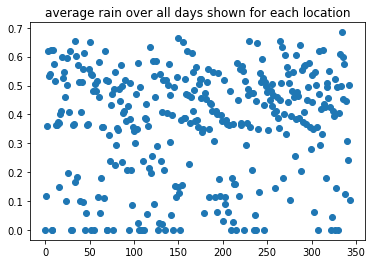

In [81]:
plt.scatter(range(len(loc_lat_lon)),[np.mean([gamma_outputs[loc][2][day] for day in range(2002)]) for loc in range(len(loc_lat_lon))])
plt.title('average rain over all days shown for each location')

Text(0.5, 1.0, 'Phi')

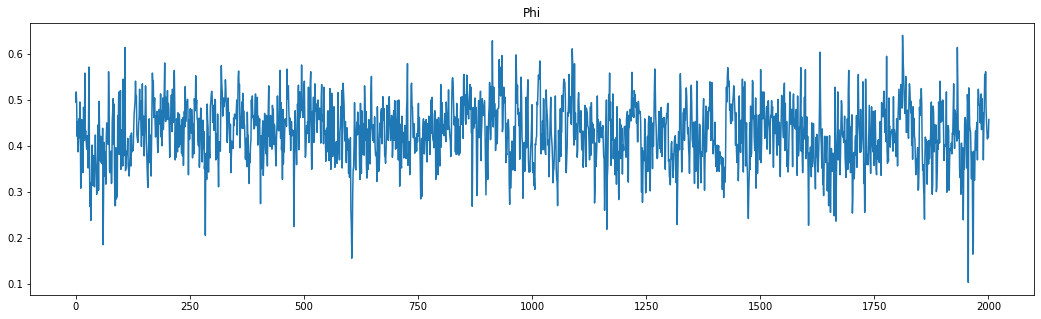

In [82]:
plt.figure(figsize=(18,5))
plt.plot(range(2002),[gamma_outputs[101][1][i][0][0] for i in range(2002)])
plt.title('Phi')

Text(0.5, 1.0, 'P')

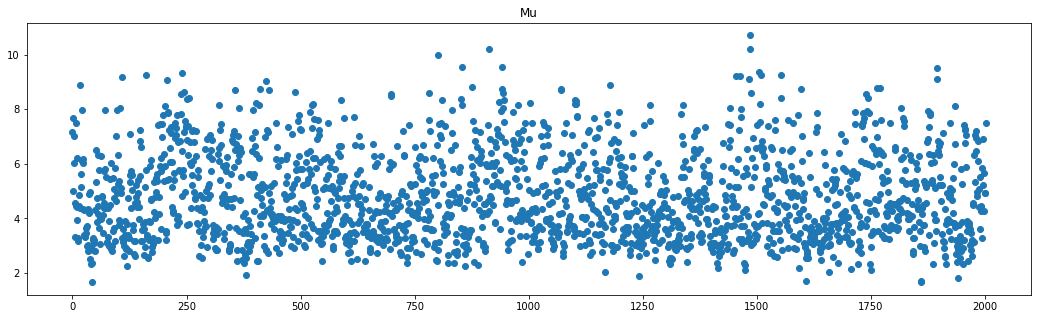

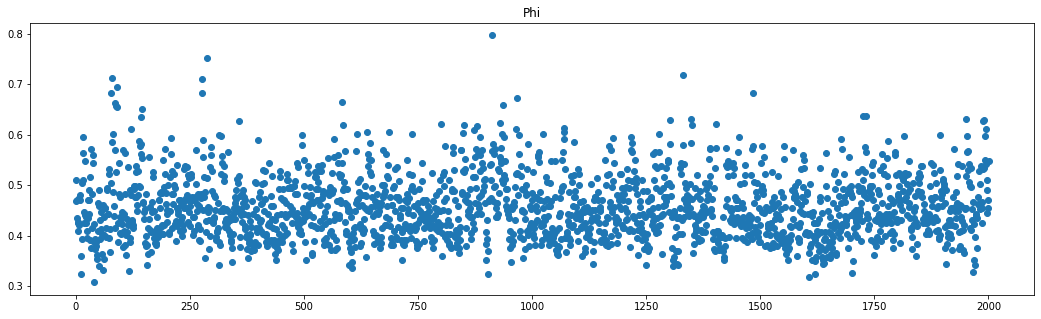

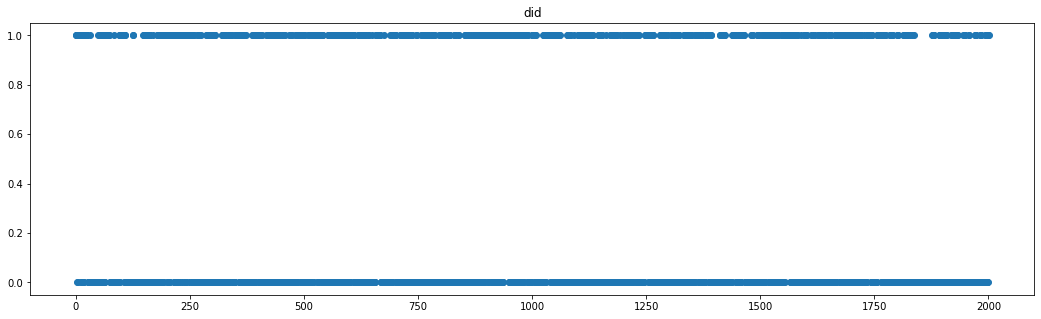

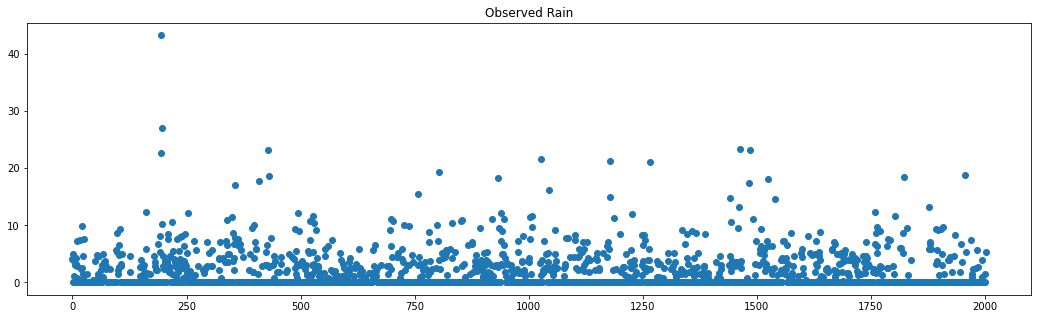

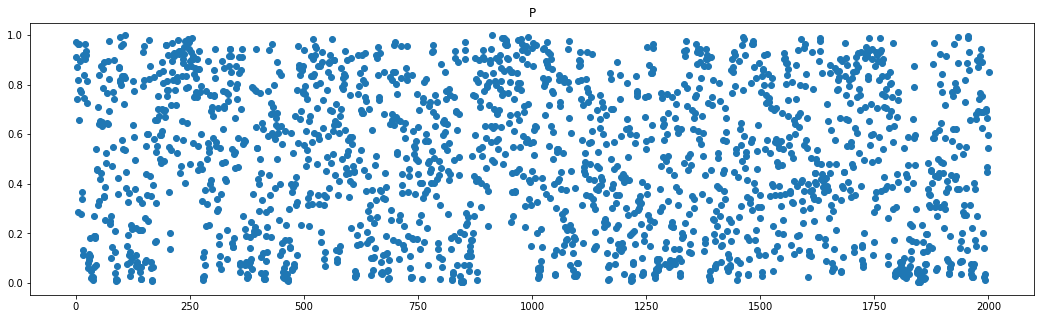

In [64]:
#inspecting parameter values
plt.figure(figsize=(18,5))
plt.scatter(range(2002),[gamma_outputs[101][0][i][0][0] for i in range(2002)])
plt.title('Mu')

plt.figure(figsize=(18,5))
plt.scatter(range(2002),[gamma_outputs[101][1][i][0][0] for i in range(2002)])
plt.title('Phi')

plt.figure(figsize=(18,5))
plt.scatter(range(2002),[gamma_outputs[101][2][i][0][0] for i in range(2002)])
plt.title('did')

plt.figure(figsize=(18,5))
plt.scatter(range(2002),[gamma_outputs[101][3][i][0][0] for i in range(2002)])
plt.title('Observed Rain')

plt.figure(figsize=(18,5))
plt.scatter(range(2002),[gamma_outputs[101][5][i][0][0] for i in range(2002)])
plt.title('P')




Setting up the map.

In [16]:
m = Basemap(projection='mill',
            resolution='i',llcrnrlat = 48,
            llcrnrlon = -12,
            urcrnrlat = 60,
            urcrnrlon = 3)
            
maped_loc = [[[],[],[],[]] for i in range(len(loc_lat_lon))]
for i in range(len(loc_lat_lon)):
    maped_loc[i][0] = m(3,gamma_outputs[i][6][0])[1]
    maped_loc[i][1] = m(3,gamma_outputs[i][6][1])[1]
    maped_loc[i][2] = m(gamma_outputs[i][6][2],3)[0]
    maped_loc[i][3] = m(gamma_outputs[i][6][3],3)[0]

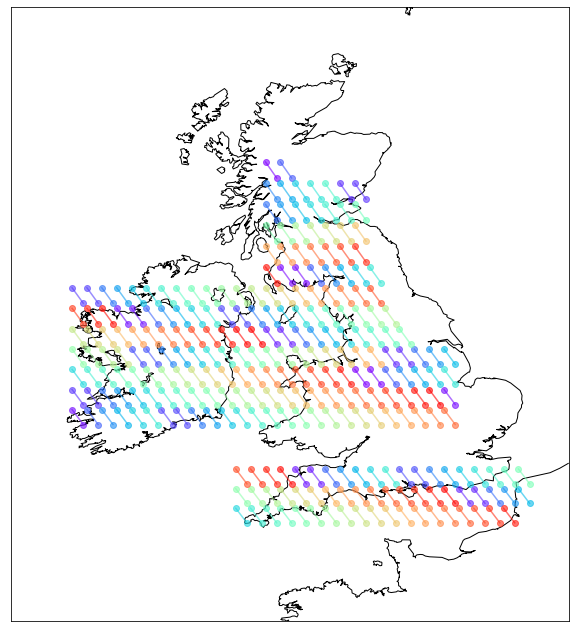

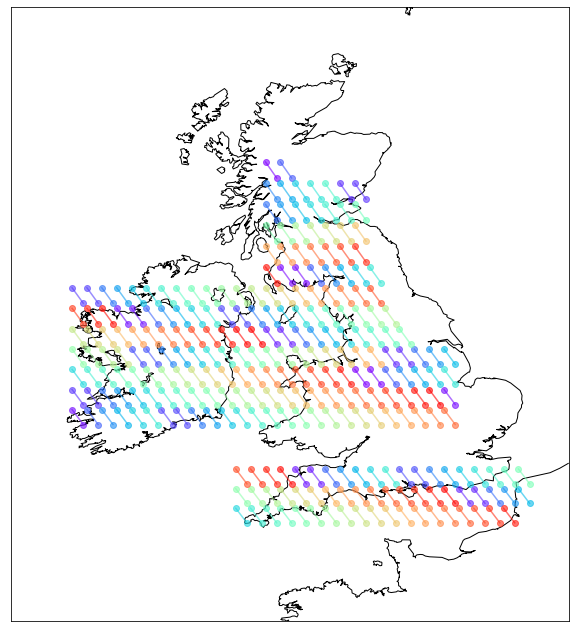

In [18]:

#locations on map
fig = plt.gcf()
fig.set_size_inches(10, 20)
dpi=300

m.drawcoastlines()   
   
'''for i in range(4):
    m.scatter(maped_loc[i][2],maped_loc[i][0],color='red')
    m.scatter(maped_loc[i][2],maped_loc[i][1],color='green')
    m.scatter(maped_loc[i][3],maped_loc[i][0],color='blue')
    m.scatter(maped_loc[i][3],maped_loc[i][1],color='orange')
'''

#ax = plt.gca()
#rect = matplotlib.patches.Rectangle((maped_loc[0][0],maped_loc[0][2]),maped_loc[0][3]-maped_loc[0][2],maped_loc[0][1]-maped_loc[0][0],facecolor='red',fill=True)
#ax.add_patch(rect)
color = matplotlib.pyplot.cm.rainbow(np.linspace(0, 1, len(loc_lat_lon)))
for i in range(len(loc_lat_lon)):
    m.plot(x=[maped_loc[i][2],maped_loc[i][3]], y=[maped_loc[i][0],maped_loc[i][1]], marker='o',color=color[i],alpha=0.6)
plt.show()


            
maped_loc = [[[],[],[],[]] for i in range(len(loc_lat_lon))]
for i in range(len(loc_lat_lon)):
    maped_loc[i][0] = m(3,gamma_outputs[i][6][0]-0.6)[1]
    maped_loc[i][1] = m(3,gamma_outputs[i][6][1]+0.7)[1]
    maped_loc[i][2] = m(gamma_outputs[i][6][2]+0.6,3)[0]
    maped_loc[i][3] = m(gamma_outputs[i][6][3]-0.7,3)[0]

fig = plt.gcf()
fig.set_size_inches(10, 20)
dpi=300

m.drawcoastlines()   
   
'''for i in range(4):
    m.scatter(maped_loc[i][2],maped_loc[i][0],color='red')
    m.scatter(maped_loc[i][2],maped_loc[i][1],color='green')
    m.scatter(maped_loc[i][3],maped_loc[i][0],color='blue')
    m.scatter(maped_loc[i][3],maped_loc[i][1],color='orange')
'''

#ax = plt.gca()
#rect = matplotlib.patches.Rectangle((maped_loc[0][0],maped_loc[0][2]),maped_loc[0][3]-maped_loc[0][2],maped_loc[0][1]-maped_loc[0][0],facecolor='red',fill=True)
#ax.add_patch(rect)
color = matplotlib.pyplot.cm.rainbow(np.linspace(0, 1, len(loc_lat_lon)))
for i in range(len(loc_lat_lon)):
    m.plot(x=[maped_loc[i][2],maped_loc[i][3]], y=[maped_loc[i][0],maped_loc[i][1]], marker='o',color=color[i],alpha=0.6)
plt.show()

Checking for overlap

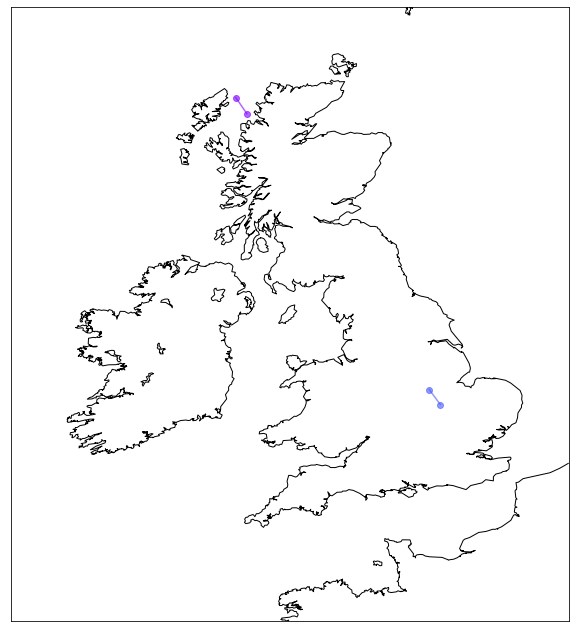

In [248]:
#locations on map
fig = plt.gcf()
fig.set_size_inches(10, 20)
dpi=300

m.drawcoastlines()   
   
'''for i in range(4):
    m.scatter(maped_loc[i][2],maped_loc[i][0],color='red')
    m.scatter(maped_loc[i][2],maped_loc[i][1],color='green')
    m.scatter(maped_loc[i][3],maped_loc[i][0],color='blue')
    m.scatter(maped_loc[i][3],maped_loc[i][1],color='orange')
'''

#ax = plt.gca()
#rect = matplotlib.patches.Rectangle((maped_loc[0][0],maped_loc[0][2]),maped_loc[0][3]-maped_loc[0][2],maped_loc[0][1]-maped_loc[0][0],facecolor='red',fill=True)
#ax.add_patch(rect)
color = matplotlib.pyplot.cm.rainbow(np.linspace(0, 1, 267))
for i in [0,31]:
    m.plot(x=[maped_loc[i][2],maped_loc[i][3]], y=[maped_loc[i][0],maped_loc[i][1]], marker='o',color=color[i],alpha=0.6)
plt.show()

In [31]:
# 0 and 31 have significant overlap. We check for the parMeter values at the same locations.
[gamma_outputs[0][3][20],gamma_outputs[31][3][20]]

[array([[ 9.099744,  9.001947,  9.099744,  9.397791],
        [ 9.099744,  9.500244,  9.798291,  9.798291],
        [ 9.695838, 10.003199, 10.301246, 10.701746],
        [10.003199, 10.096338, 11.102246, 12.098841]], dtype=float32),
 array([[ 9.299994 ,  9.602698 , 10.804199 , 11.69834  ],
        [10.599293 , 11.29784  , 11.69834  , 12.098841 ],
        [11.195386 , 12.201295 , 12.098841 , 12.396888 ],
        [12.098841 , 12.499341 , 13.0022955, 13.700843 ]], dtype=float32)]

In [48]:
#np.linspace(58.95,49.05,100) increments of 0.1
#np.linspace(-10.95,2.95,140) increments of 0.1
test_loc=[]
for loc in range(267):
    for i in range(4):
            test_loc.append(gamma_outputs[loc][6][i])

In [ ]:
gamma_outputs

Seems the values are different. But if measurements are done at same location why are they different?

- ? Because locations are for a 16*16 grid.

### Getting the Gamma distribution and Us
We use the gamma marginal.

In [7]:
# ROC calculations
from sklearn.metrics import roc_curve, auc
from scipy.special import gamma
from math import exp
import numpy as np
import scipy.stats as scs

# Gamma: alpha = 1/disp, beta = alpha/mu
# 0 'pred_mu', 1'pred_disp', 2'target_did_rain', 3'target_rain_value', 4'date', 5'pred_p', 6'location'.

g_0mm=[]
g_0mm_cdfx=[]

for place in tqdm(gamma_outputs):
    for day in range(2002):
            for row in range(4):
                for column in range(4):
                            
                    #vector of 'did it rain this much'
                    if place[3][day][row][column]>0.1:
                        g_0mm.append(1)
                    else:
                        g_0mm.append(0)
                    #vetor of 'probability it rained this much'
                    g_0mm_cdfx.append(1-((1-place[5][day][row][column])+(place[5][day][row][column]*scs.gamma(scale=place[1][day][row][column]*place[0][day][row][column],a=1/place[1][day][row][column]).cdf(0.1))))

print('0 done')

g_5mm=[]
g_5mm_cdfx=[]

for place in tqdm(gamma_outputs):
    for day in range(2002):
        for row in range(4):
                for column in range(4):
                                       
                    #vector of 'did it rain this much'
                    if place[3][day][row][column]>5:
                        g_5mm.append(1)
                    else:
                        g_5mm.append(0)
                    #vetor of 'probability it rained this much'
                    g_5mm_cdfx.append( 1-((1-place[5][day][row][column])+(place[5][day][row][column]*scs.gamma(scale=place[1][day][row][column]*place[0][day][row][column],a=1/place[1][day][row][column]).cdf(5))))
print('5 done')


g_10mm=[]
g_10mm_cdfx=[]

for place in tqdm(gamma_outputs):
    for day in range(2002):
        for row in range(4):
                for column in range(4):
                    #vector of 'did it rain this much'
                    if place[3][day][row][column]>10:
                        g_10mm.append(1)
                    else:
                        g_10mm.append(0)
                    #vetor of 'probability it rained this much'
                    g_10mm_cdfx.append(1-((1-place[5][day][row][column])+(place[5][day][row][column]*scs.gamma(scale=place[1][day][row][column]*place[0][day][row][column],a=1/place[1][day][row][column]).cdf(10))))
print('10 done')


g_15mm=[]
g_15mm_cdfx=[]

for place in tqdm(gamma_outputs):
    for day in range(2002):
        for row in range(4):
                for column in range(4):
                    #vector of 'did it rain this much'
                    if place[3][day][row][column]>15:
                        g_15mm.append(1)
                    else:
                        g_15mm.append(0)
                    #vetor of 'probability it rained this much'
                    g_15mm_cdfx.append(1-((1-place[5][day][row][column])+(place[5][day][row][column]*scs.gamma(scale=place[1][day][row][column]*place[0][day][row][column],a=1/place[1][day][row][column]).cdf(15))))
print('15 done')


g_20mm=[]
g_20mm_cdfx=[]

for place in tqdm(gamma_outputs):
    for day in range(2002):
        for row in range(4):
                for column in range(4):
                    #vector of 'did it rain this much'
                    if place[3][day][row][column]>20:
                        g_20mm.append(1)
                    else:
                        g_20mm.append(0)
                    #vetor of 'probability it rained this much'
                    g_20mm_cdfx.append(1-((1-place[5][day][row][column])+(place[5][day][row][column]*scs.gamma(scale=place[1][day][row][column]*place[0][day][row][column],a=1/place[1][day][row][column]).cdf(20))))
print('20 done')


g_25mm=[]
g_25mm_cdfx=[]

for place in tqdm(gamma_outputs):
    for day in range(2002):
        for row in range(4):
                for column in range(4):
                    #vector of 'did it rain this much'
                    if place[3][day][row][column]>25:
                        g_25mm.append(1)
                    else:
                        g_25mm.append(0)
                    #vetor of 'probability it rained this much'
                    g_25mm_cdfx.append(1-((1-place[5][day][row][column])+(place[5][day][row][column]*scs.gamma(scale=place[1][day][row][column]*place[0][day][row][column],a=1/place[1][day][row][column]).cdf(25))))
print('25 done')


 96%|█████████▌| 330/344 [1:24:40<03:34, 15.35s/it]

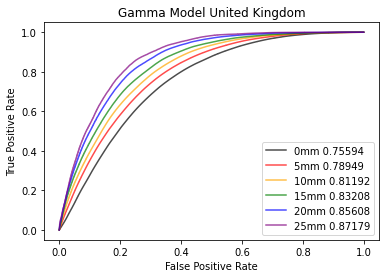

In [ ]:
# ROC plot

fpr_0mm, tpr_0mm, _ = metrics.roc_curve(g_0mm,g_0mm_cdfx)
auc0 = metrics.roc_auc_score(g_0mm,g_0mm_cdfx)
plt.plot(fpr_0mm,tpr_0mm,label='AUC='+str(auc0),color='black',alpha=0.7)

fpr_5mm, tpr_5mm, _ = metrics.roc_curve(g_5mm,g_5mm_cdfx)
auc5 = metrics.roc_auc_score(g_5mm,g_5mm_cdfx)
plt.plot(fpr_5mm,tpr_5mm,label='AUC='+str(auc5),color='red',alpha=0.7)

fpr_10mm, tpr_10mm, _ = metrics.roc_curve(g_10mm,g_10mm_cdfx)
auc10 = metrics.roc_auc_score(g_10mm,g_10mm_cdfx)
plt.plot(fpr_10mm,tpr_10mm,label='AUC='+str(auc10),color='orange',alpha=0.7)

fpr_15mm, tpr_15mm, _ = metrics.roc_curve(g_15mm,g_15mm_cdfx)
auc15 = metrics.roc_auc_score(g_15mm,g_15mm_cdfx)
plt.plot(fpr_15mm,tpr_15mm,label='AUC='+str(auc15),color='green',alpha=0.7)

fpr_20mm, tpr_20mm, _ = metrics.roc_curve(g_20mm,g_20mm_cdfx)
auc20 = metrics.roc_auc_score(g_20mm,g_20mm_cdfx)
plt.plot(fpr_20mm,tpr_20mm,label='AUC='+str(auc20),color='blue',alpha=0.7)

fpr_25mm, tpr_25mm, _ = metrics.roc_curve(g_25mm,g_25mm_cdfx)
auc25 = metrics.roc_auc_score(g_25mm,g_25mm_cdfx)
plt.plot(fpr_25mm,tpr_25mm,label='AUC='+str(auc25),color='purple',alpha=0.7)

plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(['0mm '+str(round(auc0,5)),'5mm '+str(round(auc5,5)),'10mm '+str(round(auc10,5)),'15mm '+str(round(auc15,5)),'20mm '+str(round(auc20,5)),'25mm '+str(round(auc25,5))])
plt.title('Gamma Model United Kingdom')
plt.savefig('ROC Gamma model UK')

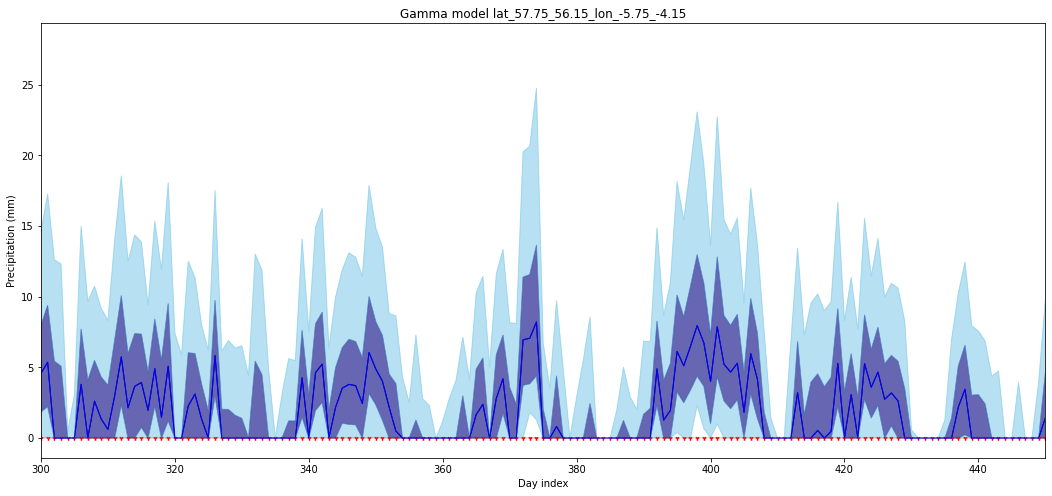

In [19]:
### plot quantiles

# Median and 68, 95 percentiles for Cardiff
import math 
import scipy.stats as scs 
import matplotlib.pyplot as plt

g_median = []
g_q25 = []
g_q75 = []
g_q68 = []
g_q95 = []
g_q32 = []
g_q05 = []

#Here:
# 0 'pred_mu', 1'pred_disp', 2'target_did_rain', 3'target_rain_value', 4'date', 5'pred_p', 6'location'.
#[place][parameter][day][row][column]
#Old:
#0:i,1:location,2:pred_mu,3:pred_disp,4:pred_p,5:target_rain_value,6:dates
for m,d,i in zip([gamma_outputs[11][0][i][0][0] for i in range(2002)],[gamma_outputs[11][1][i][0][0] for i in range(2002)],range(2002)) :
    rv = scs.gamma(scale=m*d,a=1/d)  
      
    g_median.append(rv.ppf((gamma_outputs[11][5][i][0][0]-1+0.5)/gamma_outputs[11][5][i][0][0]))
    g_q25.append(rv.ppf((gamma_outputs[11][5][i][0][0]-1+0.25)/gamma_outputs[11][5][i][0][0]))
    g_q75.append(rv.ppf((gamma_outputs[11][5][i][0][0]-1+0.75)/gamma_outputs[11][5][i][0][0]))
    g_q68.append(rv.ppf((gamma_outputs[11][5][i][0][0]-1+0.68)/gamma_outputs[11][5][i][0][0]))
    g_q95.append(rv.ppf((gamma_outputs[11][5][i][0][0]-1+0.95)/gamma_outputs[11][5][i][0][0]))
    g_q32.append(rv.ppf((gamma_outputs[11][5][i][0][0]-1+0.32)/gamma_outputs[11][5][i][0][0]))
    g_q05.append(rv.ppf((gamma_outputs[11][5][i][0][0]-1+0.05)/gamma_outputs[100][5][i][0][0]))

for q in [g_median,g_q25,g_q05,g_q32,g_q68,g_q75,g_q95]:
    for i in range(len(q)):
        if math.isnan(q[i]):
            q[i]=0
            
plt.figure(figsize=(18, 8))

plt.plot(range(2002),g_q05,color='skyblue',linewidth=0.6,alpha=0.3)
plt.plot(range(2002),g_q25,color='navy',linewidth=0.6,alpha=0.3)
plt.plot(range(2002),g_median,color='blue',linewidth=1,alpha=1)
plt.plot(range(2002),g_q75,color='navy',linewidth=0.6,alpha=0.3)
plt.plot(range(2002),g_q95,color='skyblue',linewidth=0.6,alpha=0.3)
plt.fill_between(range(2002), g_median, g_q75, where=([g_median[k] < g_q75[k] for k in range(len(gamma_outputs[11][5]))]), color='navy', alpha=0.6,interpolate=True)
plt.fill_between(range(2002), g_median, g_q25, where=([g_median[k] > g_q25[k] for k in range(len(gamma_outputs[11][5]))]), color='navy', alpha=0.6,interpolate=True)
plt.fill_between(range(2002), g_q95, g_q75, where=([g_q95[k] > g_q75[k] for k in range(len(gamma_outputs[11][5]))]), color='skyblue', alpha=0.6,interpolate=True)
plt.fill_between(range(2002), g_q05, g_q25, where=([g_q05[k] < g_q25[k] for k in range(len(gamma_outputs[11][5]))]), color='skyblue', alpha=0.6,interpolate=True)
plt.scatter(range(2002),[gamma_outputs[11][3][i][0][0] for i in range(2002)],color='r',marker='1',s=20)
plt.plot(range(2002),[gamma_outputs[11][3][i][0][0] for i in range(2002)],color='r',alpha=0.6,linewidth=0.3)
plt.xlim([range(2002)[300],range(2002)[450]])
plt.title('Gamma model lat_57.75_56.15_lon_-5.75_-4.15')
plt.xlabel('Day index')
plt.ylabel('Precipitation (mm)')
plt.savefig('Gamma_lat_57 75_56 15_lon_-5 75_-4 15')

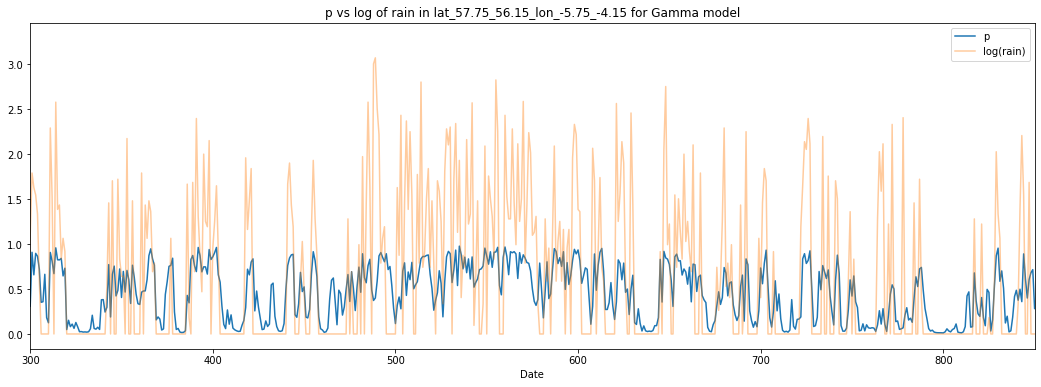

In [20]:
#p plot gamma
import numpy as np
from matplotlib import pyplot as plt
plt.figure(figsize=(18, 6))
plt.plot(range(2002),[gamma_outputs[1][5][i][0][0] for i in range(2002)])
plt.plot(range(2002),[0 if rain<1 else np.log(rain) for rain in [gamma_outputs[1][3][i][0][0] for i in range(2002)]],'-',alpha=0.4)
plt.xlabel('Date')
plt.xlim([range(2002)[300],range(2002)[850]])
plt.legend(['p','log(rain)'],facecolor='white')
plt.title('p vs log of rain in lat_57.75_56.15_lon_-5.75_-4.15 for Gamma model')
plt.savefig('gamma_p_UK')


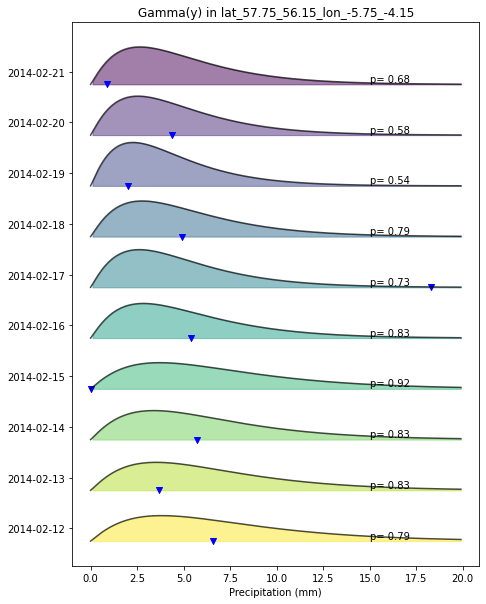

In [22]:
### densities plots
import matplotlib
import pandas as pd
import sklearn.preprocessing
x=[i/10 for i in range(200)]

plt.figure(figsize=(7.3, 10))
colors = matplotlib.cm.viridis(np.linspace(0, 1, len(range(959,969))))
for idx,col in zip(range(968,958,-1),colors):
    rv=scs.gamma(scale=[gamma_outputs[101][1][i][0][0] for i in range(2002)][idx]*[gamma_outputs[101][0][i][0][0] for i in range(2002)][idx],a=1/[gamma_outputs[101][1][i][0][0] for i in range(2002)][idx])
    level=((idx-300)*0.2)
    plt.plot(x,level+rv.pdf(x),color='black',alpha=0.7)
    plt.fill_between(x,y1=level+rv.pdf(x),y2=level,where=([level+rv.pdf(x_)>level for x_ in x]),color=col,alpha=0.5)
    plt.text(15,level+0.01,'p= '+str(round([gamma_outputs[101][5][i][0][0] for i in range(2002)][idx],2)))
    plt.scatter([gamma_outputs[101][3][i][0][0] for i in range(2002)][idx],level,marker='v',color='b')
plt.xlabel('Precipitation (mm)')
plt.yticks([131.85+0.2*k for k in range(10)],["2014-02-12",
"2014-02-13",
"2014-02-14",
"2014-02-15",
"2014-02-16",
"2014-02-17",
"2014-02-18",
"2014-02-19",
"2014-02-20",
"2014-02-21"])
plt.title('Gamma(y) in lat_57.75_56.15_lon_-5.75_-4.15')
plt.savefig('gamma_dists')

In [ ]:
#Saving data
import pickle

with open('g2_0mm.txt','wb') as f:
    pickle.dump(g_0mm,f)

with open('g2_0mm_cdfx.txt','wb') as f:
    pickle.dump(g_0mm_cdfx,f)

with open('g2_10mm.txt','wb') as f:
    pickle.dump(g_10mm,f)

with open('g2_10mm_cdfx.txt','wb') as f:
    pickle.dump(g_10mm_cdfx,f)

with open('g2_15mm.txt','wb') as f:
    pickle.dump(g_15mm,f)

with open('g2_15mm_cdfx.txt','wb') as f:
    pickle.dump(g_15mm_cdfx,f)

with open('g2_20mm.txt','wb') as f:
    pickle.dump(g_20mm,f)

with open('g2_20mm_cdfx.txt','wb') as f:
    pickle.dump(g_20mm_cdfx,f)

with open('g2_25mm.txt','wb') as f:
    pickle.dump(g_25mm,f)

with open('g2_25mm_cdfx.txt','wb') as f:
    pickle.dump(g_25mm_cdfx,f)
